In [84]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import signal
from behavior_utils import *

In [85]:
flip_paths =  get_file_paths('D:/data/clickbait-motivate', extension='npy', keyword='reward_state', session_type='m', print_paths=True, print_n=20)
events_paths = get_file_paths('D:/data/clickbait-motivate/bonsai', extension='csv', keyword='events', session_type='m', keyword_exact=True, print_paths=True, print_n=20)
flip_paths = filter_paths(flip_paths, events_paths)

Found 74 reward_state.npy files
0 D:\data\clickbait-motivate\preprocessed\7010\m1\reward_state.npy
1 D:\data\clickbait-motivate\preprocessed\7010\m2\reward_state.npy
2 D:\data\clickbait-motivate\preprocessed\7010\m4\reward_state.npy
3 D:\data\clickbait-motivate\preprocessed\7010\m5\reward_state.npy
4 D:\data\clickbait-motivate\preprocessed\7010\m6\reward_state.npy
5 D:\data\clickbait-motivate\preprocessed\7010\m7\reward_state.npy
6 D:\data\clickbait-motivate\preprocessed\7010\m8\reward_state.npy
7 D:\data\clickbait-motivate\preprocessed\7010\m9\reward_state.npy
8 D:\data\clickbait-motivate\preprocessed\7010\m10\reward_state.npy
9 D:\data\clickbait-motivate\preprocessed\7010\m11\reward_state.npy
10 D:\data\clickbait-motivate\preprocessed\7010\m12\reward_state.npy
11 D:\data\clickbait-motivate\preprocessed\7010\m13\reward_state.npy
12 D:\data\clickbait-motivate\preprocessed\7010\m14\reward_state.npy
13 D:\data\clickbait-motivate\preprocessed\7010\m15\reward_state.npy
14 D:\data\clickbait

In [86]:
# Build DataFrame with event and ephys data
flip_names = [f"{flip_path.parent.parent.name}-{flip_path.parent.name}" for flip_path in flip_paths]
events_names = [f"{event_path.parent.parent.name}-{event_path.parent.name}" for event_path in events_paths]
dataframe = pd.DataFrame({'flip_state': flip_names, 'events': events_names})
dataframe

,flip_state,events
0,7010-m1,7010-m1
1,7010-m2,7010-m2
2,7010-m4,7010-m4
3,7010-m5,7010-m5
4,7010-m6,7010-m6
...,...,...
68,7013-m16,7013-m16
69,7013-m17,7013-m17
70,7013-m18,7013-m18
71,7013-m19,7013-m19


In [ ]:
def find_offset(dataframe, event_bool):
    # Get first False->True transition in reward_state column
    reward_state_transitions = np.diff(dataframe['reward_state'].astype(int)) == 1
    first_reward_transition_idx = np.where(reward_state_transitions)[0][0]
    
    # The transition happens *between* indices, so add 1 to get the True value index
    first_reward_transition_idx += 1
    first_event_time = dataframe.loc[first_reward_transition_idx, 'timestamp_ms']

    # Get initial timestamp from dataframe
    initial_timestamp = int(dataframe['timestamp'].iloc[0])
    
    # Get first 0->1 transition in event_bool AFTER initial_timestamp
    bool_transitions = np.where(np.diff(event_bool.astype(int)) == 1)[0] + 1
    
    # Filter for transitions that occur after initial_timestamp
    valid_bool_transitions = bool_transitions[bool_transitions > initial_timestamp]
    first_bool_transition_sample = valid_bool_transitions[0]
    
    # Calculate offset (timestamp of reward - sample number of bool transition)
    event_difference = int(first_event_time) - first_bool_transition_sample
    
    return event_difference

In [ ]:
# def find_offset(dataframe, event_bool, transition_index=0):
#     """
#     Find offset between reward_state and event_bool transitions.
    
#     Parameters:
#     -----------
#     dataframe : pd.DataFrame
#         DataFrame with 'reward_state' and 'timestamp_ms' columns
#     event_bool : np.array
#         Boolean array with millisecond sampling
#     transition_index : int, default=0
#         Which transition to use for alignment.
#         0 = first, 1 = second, -1 = last, -2 = penultimate, etc.
    
#     Returns:
#     --------
#     int : Offset between transitions
#     """
#     # Get False->True transitions in reward_state column
#     reward_state_transitions = np.diff(dataframe['reward_state'].astype(int)) == -1
#     reward_transition_indices = np.where(reward_state_transitions)[0]
    
#     target_reward_transition_idx = reward_transition_indices[transition_index]
#     target_event_time = dataframe.loc[target_reward_transition_idx, 'timestamp_ms']
    
#     # Get initial timestamp from dataframe
#     initial_timestamp = int(dataframe['timestamp_ms'].iloc[0])
    
#     # Get 1->0 transitions in event_bool AFTER initial_timestamp
#     bool_transitions = np.where(np.diff(event_bool.astype(int)) == -1)[0]
    
#     # Filter for transitions that occur after initial_timestamp
#     valid_bool_transitions = bool_transitions[bool_transitions > initial_timestamp]
    
#     target_bool_transition_sample = valid_bool_transitions[transition_index]
    
#     # Calculate offset (timestamp of reward - sample number of bool transition)
#     event_difference = int(target_event_time) - target_bool_transition_sample
    
#     return event_difference

In [95]:
def find_offset_from_end(dataframe, event_bool):
    # Get last True->False transition in reward_state column
    reward_state_transitions = np.diff(dataframe['reward_state'].astype(int)) == -1
    last_reward_transition_idx = np.where(reward_state_transitions)[0][-1]
    
    # The transition happens *between* indices, so add 1 to get the False value index
    # But we want the timestamp of the last True, so use the index before the transition
    last_event_time = dataframe.loc[last_reward_transition_idx, 'timestamp_ms']
    
    # Get final timestamp from dataframe
    final_timestamp = int(dataframe['timestamp_ms'].iloc[-1])
    
    # Get last 1->0 transition in event_bool BEFORE final_timestamp
    bool_transitions = np.where(np.diff(event_bool.astype(int)) == -1)[0]
    
    # Filter for transitions that occur before final_timestamp
    valid_bool_transitions = bool_transitions[bool_transitions < final_timestamp]
    last_bool_transition_sample = valid_bool_transitions[-1]
    
    # Calculate offset (timestamp of reward - sample number of bool transition)
    event_difference = int(last_event_time) - last_bool_transition_sample
    
    return event_difference

In [98]:
def find_offset_from_penultimate(dataframe, event_bool):
    # Get penultimate True->False transition in reward_state column
    reward_state_transitions = np.diff(dataframe['reward_state'].astype(int)) == -1
    transition_indices = np.where(reward_state_transitions)[0]
    penultimate_reward_transition_idx = transition_indices[-2]
    penultimate_event_time = dataframe.loc[penultimate_reward_transition_idx, 'timestamp_ms']
    
    # Get final timestamp from dataframe
    final_timestamp = int(dataframe['timestamp_ms'].iloc[-1])
    
    # Get penultimate 1->0 transition in event_bool BEFORE final_timestamp
    bool_transitions = np.where(np.diff(event_bool.astype(int)) == -1)[0]
    
    # Filter for transitions that occur before final_timestamp
    valid_bool_transitions = bool_transitions[bool_transitions < final_timestamp]
    penultimate_bool_transition_sample = valid_bool_transitions[-2]
    
    # Calculate offset (timestamp of reward - sample number of bool transition)
    event_difference = int(penultimate_event_time) - penultimate_bool_transition_sample
    
    return event_difference

difference: -13

Processing 7010-m1
difference: 124079


c:\ProgramData\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


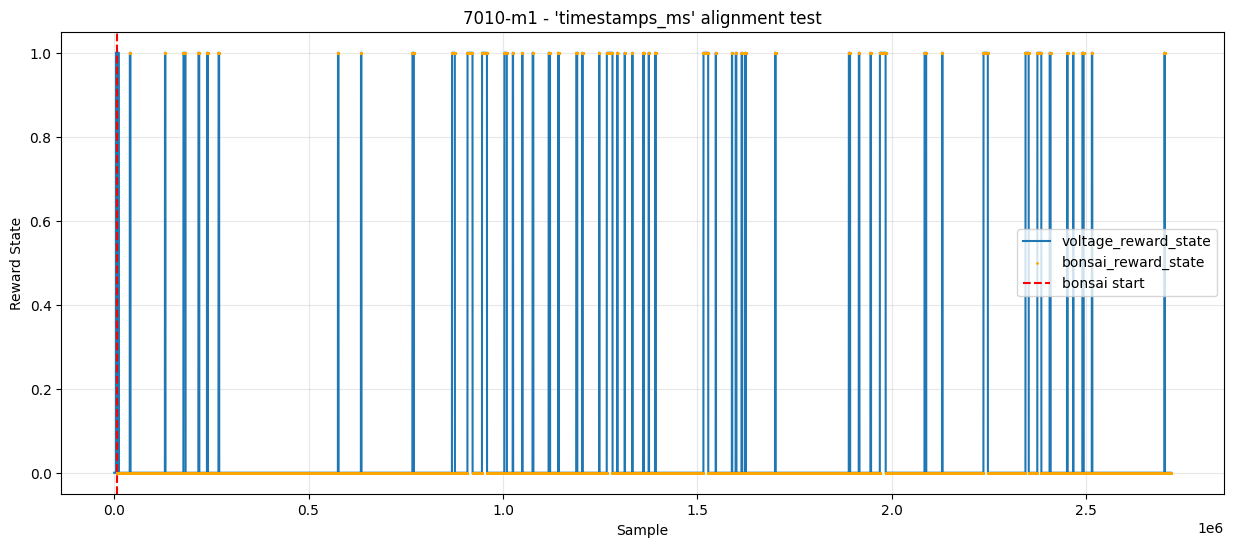

difference: -47

Processing 7010-m2
difference: 69078


<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [ ]:
for ii in range(len(dataframe)):
    try:
        # Load flip state data
        flip_state = np.load(flip_paths[ii])
        flip_bool = flip_state > 0

        # Load events data
        events_data = pd.read_csv(events_paths[ii])

        # # Old version (works)
        # def align_timestamps(events_data, flip_bool):
        #     # Get first reward_state = True timestamp greater than initial 'timestamp_ms' value
        #     initial_timestamp = events_data['timestamp_ms'].iloc[0]
        #     matching_rows_true = events_data[
        #         (events_data['timestamp_ms'] > initial_timestamp) & 
        #         (events_data['reward_state'] == True)]
        #     first_reward_idx = matching_rows_true.index[0] if len(matching_rows_true) > 0 else None
        #     first_reward_time = events_data.loc[first_reward_idx, 'timestamp_ms']
        
        #     # Get first low-to-high transition in flip_bool after initial timestamp
        #     high_transitions = np.where(np.diff(flip_bool.astype(int)) == 1)[0]
        #     valid_high_transitions = high_transitions[high_transitions > initial_timestamp + 2000]  # adding 2000 ms buffer to avoid edge cases

        #     # Calculate reward time difference
        #     reward_difference = first_reward_time - valid_high_transitions[0]
        #     return reward_difference
        # reward_difference = align_timestamps(events_data, flip_bool)    

        # New version (more robust):
        reward_difference = find_offset_from_penultimate(events_data, flip_bool)

        print(f"difference: {reward_difference}")
        
        print(f"\nProcessing {dataframe['flip_state'][ii]}")


        events_data['timestamp_ms'] = events_data['timestamp_ms'] - reward_difference
        reward_difference = find_offset(events_data, flip_bool, transition_index=1) 
        print(f"difference: {reward_difference}")
        
        # print(final_reward_time)
        # print(low_transitions[-1])


        # Create the plot
        plt.figure(figsize=(15, 6))
        plt.plot(flip_bool[:events_data['timestamp_ms'].iloc[-1]], label='voltage_reward_state')
        plt.scatter(events_data['timestamp_ms'].iloc[:-1], events_data['reward_state'].iloc[:-1], color='orange', label='bonsai_reward_state', zorder=5, s=1)

        #plt.scatter(valid_transitions[0],.5, color='cyan', label='first_voltage_reward', zorder=6)
        #plt.scatter(first_reward_time-reward_difference,1, color='green', label='first_bonsai_reward', zorder=6)

        #plt.scatter(low_transitions[-1],.5, color='red', label='first_bonsai_reward', zorder=6)

        plt.axvline(events_data['timestamp_ms'].iloc[0], color='r', linestyle='--', label='bonsai start')
        plt.xlabel('Sample')
        plt.ylabel('Reward State')
        plt.title(f"{dataframe['flip_state'][ii]} - 'timestamps_ms' alignment test")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # save svg
        svg_path = Path(f"svg_test/{dataframe['flip_state'][ii]}_ttl_sync.svg")
        plt.savefig(svg_path, format='svg')

    except Exception as e:
        print(f"Error processing {dataframe['flip_state'][ii]}: {e}")
        continue

In [ ]:
events_data['timestamp_ms'].iloc[0]

1